In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import plotly.express as px 
sys.path.insert(1, "../src/utils/")
from agent import Environment
from Q_learning import QLearningTrainer
sys.path.insert(1, "plotly_graph/")
from functions4tuto import plotly_trajectory, control_fall_simulation, booster_reward, plotly_all_reward
JOSN_file = "rocket_tuto_2.json"

# <span style="color:orange">Input file</span>

In the previous tutorial we defined our environment and designed reward function. The system is a rocket that falling from a starting point and the goal is to reach a target with a minimum speed and maximize fuel.
Variable's names, their initial values and boundaries limit are defined into a JSON file (or can be given directly into a dictionary)

## <span style="color:orange">Variables</span>

Variables can be categorize into 3 classes:
* `states_variables` : variable used as coordinate to describe our system
* `agent_variables` : variable use as agent. Their values are changed for each iteration
* 3th category are other variables. They are not used to describe our environment but they can be usefull to monitor information or to compute intermediate value. 
  There is no key for this kind of variable. Consider them as variables present into `initial_values` field and that are not `states_variables` and `agent_variables`

You can access to the name of state and agent variables, with the attibute `states_variables` and `agent_variables`.

    "states_variables" : ["pos_y", "acceleration_y", "speed_y"],
    "agent_variables" : ["booster"]

## <span style="color:orange">Initial system</span>

After to name `states_variables` and `agent_variables`, next step is to define initial state.
It will be use as environment coordinates at the beginning of each episode. Initially, it comprises 
the values of state_variables, followed by agent_variables, and finally other variables that are 
not used for the system's coordinates.

    "initial_values" : {
      "pos_y" : [175.0],
      "acceleration_y": [0.0],
      "speed_y": [0.0],
      "angle" : [0.0],
      "booster" : [0.0],
      "alpha" : [0.0],
      "futur_pos_y" : [175.0],
      "m_fuel" : [100],
      "weight_rocket" : [105],
      "weight_dry_rocket" : [5],
      "G" : [1.62],
      "m_fuel_ini" : [100.0],
      "pos_y_star": [0.0],
      }


## <span style="color:orange">Limit</span>

Q-learning algorithms model events as a Markov process. Therefore, it is necessary to discretize our environment space. 
We define lower and upper bounds, as well as the number of divisions we want to use to discretize the variable space.


    "limit" : {
      "pos_y" : [0.0, 300.0, 61],
      "acceleration_y": [-20.0, 20.0, 21],
      "speed_y": [-50.0, 50.0, 21],
      "angle" : [-0.8, 0.8, 17],
      "booster" : [0.0, 1.0, 3],
      "alpha" : [-0.1, 0.1, 3],
      "m_fuel" : [0.0, 100, 201]
    }


## <span style="color:orange">Agents's actions</span>
    "n_action" : {
      "booster": {"0" : 0.0, "1" : 0.5, "2" : 1.0}
    }

After defining the variables and their initial values, we proceed to define actions that apply to the agent variables. In this example, we have 1 agent that can take 3 actions:

For the booster:
  * "0": Booster is off.
  * "1": Booster is turned on to half of its power.
  * "2": Booster is turned on to its full power.

## <span style="color:orange">Actions to take</span>

    "action_to_take" : {
      "booster": {"$booster$" : "$action}
    }

Actions change the agent variables by modifying their values based on the action taken, which are retrieved from the n_action dictionary. You can change default delimiter during the initilisation:

`agent = Environment(json_file, delimiter = "Char_you_want")`

## <span style="color:orange">System's evolution and reward</span>

Last fields are how variables evolve after agents's action and how reward are computed.
Only variables present in field inital value are stored. Other variables present are just temporary and are lost after each iteration.
Reward values are stored into a dictionnary, the keys are agent variable's name. 

### <span style="color:orange">Equation variables</span>

    "equations_variables": {
        "$F$" : "600",
        "$m_fuel$" : "$m_fuel$ - $booster$ *10 -$angle$ *10",
        "$weight_rocket$" : "$weight_dry_rocket$ + $m_fuel$",
        "dt" : "0.5",
        "$theta$" : "0.0",
        "$y_0$" : "$pos_y$",
        "$Vy_0$" : "$speed_y$",
        "$angle$" : "$theta$ + $alpha$",
        "$acceleration_y$" : "($F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ - $G$",
        "$speed_y$" : "($F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ * $dt$ - $G$ * $dt$ + $Vy_0$",
        "$pos_y$": "(0.5 * $F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ * $dt$**2 - $G$ * $dt$**2 + $Vy_0$ * $dt$ + $y_0$",
        "$futur_pos_y$" : "$pos_y$ + 3 * $speed_y$"
    },

### <span style="color:orange">Reward</span>

The reward indicates the immediate benefit or cost associated with the action.
The scalar feedback signal that the environment sends to the agent after it takes an action are defined into this dictionnary.

    "equations_rewards": {
      "$booster$" : "-($pos_y$ - $pos_y_star$)**2 + $m_fuel$/$m_fuel_ini$"
    }

## <span style="color:orange">Stop episode</span>

stop episode when goal is reach. If feature has 1 value, its feature's value must be equal.
In other hand, if feature has 2 values ([min_limit, max_limit]), criterion is bounded feature >= min_limit and feature <= max_limit

    "stop_episode" : {
      "pos_y" : [0, 5],
      "acceleration_y" : [-2,2],
      "speed_y" : [-2,2]
    }

# <span style="color:orange">Intialize environment</span>

Create an environment object with the rules defined previously. The idea is to check the new field can raise a flag to stop simulation when the criteria are reached:

* 0 <= pos_y >= 10
* -2 <= acceleration_y >= 2
* -10 <= speed_y >= 10 


In [3]:
# Create an environment object with the rules defined previously
env = Environment(JOSN_file, check_model = False)
flag = "0"
flag_to_continue = True
acceleration_y_constraint = 5
speed_y_limit = 10
y_lower_limit = 0
# monitor action takes for each iteration
actions = {"action_booster" : []} 
while flag_to_continue:    
    current_state, rewards, done, problem, info = env.step([flag, 1])
    actions["action_booster"].append(flag)
    if env.futur_pos_y[-1] < 0 and env.m_fuel[-1] > 0:
        flag = "1"
    # stop engine if there is no fuel
    elif env.m_fuel[-1] <= 0:
        flag = "0"
    elif np.abs(env.speed_y[-1]) > speed_y_limit:
        # print("speed limit")
        if env.speed_y[-1] > 0:
            flag = "0"
        else:
            flag = "1"
    elif np.abs(env.acceleration_y[-1]) > acceleration_y_constraint:
        # print("acceleration limit")
        if env.acceleration_y[-1] > 0:
            flag = "0"
        else:
            flag = "1" 
    # stop simulation
    if env.pos_y[-1] < 0:
        flag_to_continue = False
        # delete last state because rocket is bellow to the ground
        env.delete_last_states()
        continue
    if any(done) and info[0] == "Reach goal":
        print({val : current_state[val] for val in ['pos_y', 'acceleration_y', 'speed_y', 'booster']})

stop episode because agent reach goal
{'pos_y': array([9.20746229]), 'acceleration_y': array([-1.62]), 'speed_y': array([-3.14923886]), 'booster': array([0.])}
stop episode because agent reach goal
{'pos_y': array([8.14730457]), 'acceleration_y': array([-1.62]), 'speed_y': array([-9.73923886]), 'booster': array([0.])}


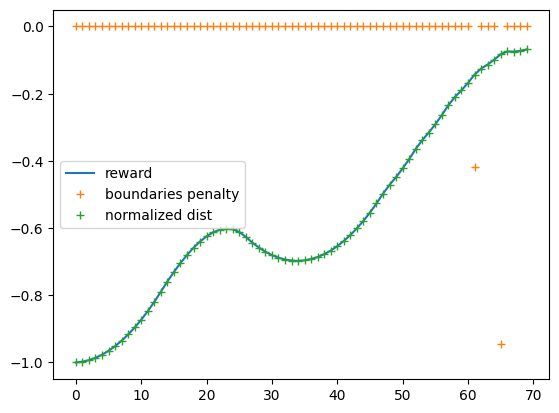

In [4]:
end  = 70
dt = pd.DataFrame(env.all_states())
plt.plot(pd.DataFrame(env.rewards)[:end], 
         label = "reward")
plt.plot(np.array(
    [-2 + np.exp(np.min([val1, 0])) + np.exp(np.min([val2, 0])) 
     for val1, val2 in zip(
         dt["futur_pos_y"] - 0, - dt["futur_pos_y"] + 200
         ) ])[:end], "+", label = "boundaries penalty")
plt.plot(-(dt['pos_y'][:70]-dt['pos_y_star'][:end])/(dt['pos_y'].max() - dt['pos_y_star']), 
         "+", label = "normalized dist")
plt.legend()

In [5]:
dt = pd.DataFrame(env.all_states())
dt["iter"] = np.arange(0, dt.shape[0])
dt["reward"] = env.rewards['booster']

fig = px.scatter_3d(dt[:70], 
                    x='pos_y', 
                    y='speed_y', 
                    z='acceleration_y',
              color='reward')
fig.show()

## <span style="color:orange">Reinforcemet learning</span>


After load our environment, next step is to create QLearningTrainer objet. It will apply Qlearning algorithm. For each states, the algorithm will apply a score base to the next iteration.

The Bellman equation is the value function use in reinforcement learning. 

$v(s) = (1−\alpha) * V(s)+ \alpha * (R+\gamma * V(s'))$

Where:

* $V(s)$ is the estimated value of state $s$ * $s$ is the curent state
* $s'$ is the next state.
* $R$ is the immediate reward received after transitioning from state $s$ to state
* $\gamma$ is the discount factor, which determines the importance of future rewards.
* $\alpha$ is the learning rate.
s.l difference (TD) learning methods.

In [6]:
# Load RL object
env = Environment(JOSN_file, check_model = True)
RL = QLearningTrainer(env, num_episodes = 800, convergence_criterion = 0.5, decay_type = "exponential")

check order names for states_variables

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)


Different parameters are avaible. For the tutorial, you use default parameters. Before to lunch training. Lets discus about the input parameters.

### <span style="color:orange">Learning rate</span>


The learning rate $\alpha$ in the Bellman equation controls the weight given to the new estimate compared to the existing estimate of the state value. A smaller learning rate means that the new estimate has less influence, and the agent is more conservative in updating its value function. A larger learning rate allows the agent to adjust its estimates more rapidly based on new information

### <span style="color:orange">Discount factor ($\gamma$)</span>


### <span style="color:orange">Epsilon parameter</span>

Exploration-exploitation is a fundamental trade-off in reinforcement learning, where the agent needs to balance between exploring new actions and exploiting the knowledge it has gained so far.

The epsilon-greedy policy is a simple strategy that the agent uses to decide whether to explore a new action (random exploration) or exploit the current best-known action. It helps prevent the agent from getting stuck in suboptimal policies by occasionally trying new actions. The value of epsilon determines the probabilty the agent chooses a random action. A higher epsilon encourages more exploration, while a lower epsilon emphasizes exploitation of the current best-known actions.ent knowledge.

The epsilon parameter is decayed over time during training. This means that, as the agent gains more experience, it tends to rely more on exploitation and less on exploration. The idea is that, as the agent learns and becomes more confident in its estimates, it gradually reduces the rate of exploration. 

Epsilon initailization is made with the argument **exploration_prob**. It is a list with the lowest and the highest probability values. The probability will decrease with a rate given by the argument **decrease_prob_exp**. By default epsilon is modeled with a linear decay but you can change it to a exponential decay.


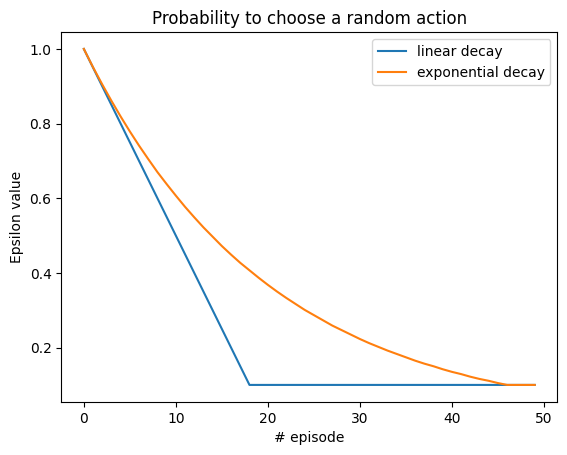

In [7]:
plt.plot(RL.get_epsilon(decay_type = 'linear')[0:50], label = "linear decay")
plt.plot(RL.get_epsilon(decay_type = 'exponential')[0:50], label = "exponential decay")
plt.title("Probability to choose a random action")
plt.legend()
plt.xlabel("# episode")
plt.ylabel("Epsilon value")
plt.show()

### <span style="color:orange">num_episodes, run_limit and convergence_criterion</span>

The last three options are hyperparameters. They impact computation time. **num_episodes** is the maximum number of epochs used for training. **run_limit** controls the maximum number of iterations before stopping one episode. **convergence_criterion** is the threshold (difference score between two iterations) to determine convergence.


In [8]:
RL.q_learning()

Episode 1/800
exploration_prob : 1.000
current_state :  ([175.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-1.00591429]
updated_q :  [-0.19978266]
current_state :  ([175.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-1.00754286]
updated_q :  [-0.20033817]
current_state :  ([176.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-1.01362406]
updated_q :  [-0.20132863]
current_state :  ([177.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-1.03026139]
updated_q :  [-0.20386249]
current_state :  ([178.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-1.04757813]
updated_q :  [-0.20700423]
current_state :  ([181.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-1.06847344]
updated_q :  [-0.2108224]
current_state :  ([184.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-1.08419732]
updated_q :  [-0.21418288]
current_state :  ([187.0],)
le

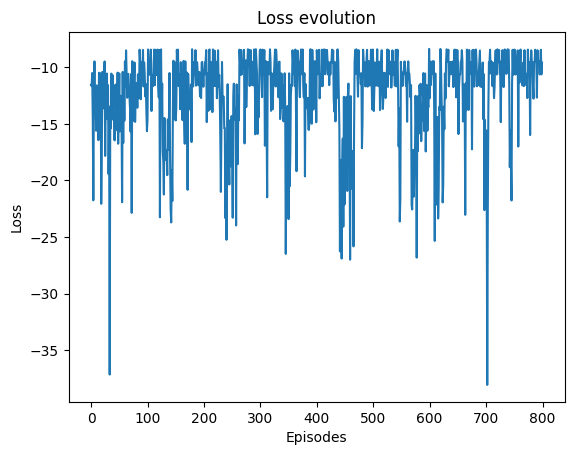

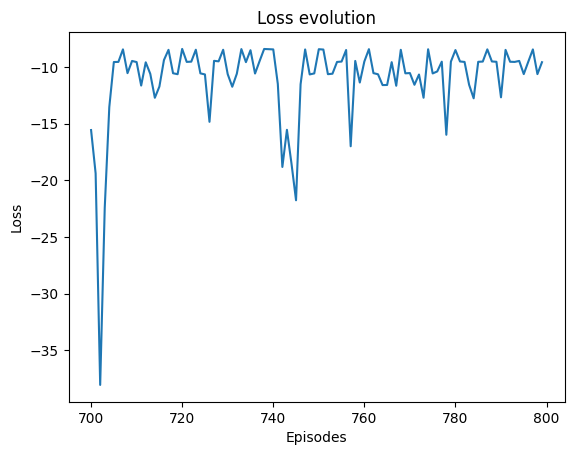

In [9]:
RL.plot_convergence()
RL.plot_convergence(start = 700)

In [10]:
pd.DataFrame(RL.env.all_states())

,pos_y,acceleration_y,speed_y,booster,angle,alpha,m_fuel,futur_pos_y,weight_rocket,weight_dry_rocket,G,m_fuel_ini,pos_y_star,pos_y_ini
0,175.000000,0.000000,0.000000,0.0,0.0,0.0,100.0,175.000000,105.0,5,1.62,100.0,0.0,175.0
1,175.345000,4.380000,2.190000,1.0,0.0,0.0,90.0,181.915000,95.0,5,1.62,100.0,0.0,175.0
2,176.868333,5.046667,4.713333,1.0,0.0,0.0,80.0,191.008333,85.0,5,1.62,100.0,0.0,175.0
3,179.757500,5.880000,7.653333,1.0,0.0,0.0,70.0,202.717500,75.0,5,1.62,100.0,0.0,175.0
4,183.679167,2.380000,8.843333,0.5,0.0,0.0,65.0,210.209167,70.0,5,1.62,100.0,0.0,175.0
5,188.231548,2.665714,10.176190,0.5,0.0,0.0,60.0,218.760119,65.0,5,1.62,100.0,0.0,175.0
6,192.914643,-1.620000,9.366190,0.0,0.0,0.0,60.0,221.013214,65.0,5,1.62,100.0,0.0,175.0
7,198.442738,8.380000,13.556190,1.0,0.0,0.0,50.0,239.111310,55.0,5,1.62,100.0,0.0,175.0
8,206.315833,10.380000,18.746190,1.0,0.0,0.0,40.0,262.554405,45.0,5,1.62,100.0,0.0,175.0


# <span style="color:orange">Optimal trajectory</span>

Lets see how the rocket evolves after train.

In [11]:
# load policy table
policy = RL.q_table.copy().replace(0, np.nan)
# load environnment
env = Environment(JOSN_file, check_model = False)
state = env.state_for_q_table()
flag_continue = True
while flag_continue:
    # control while loop
    if not policy.index.isin([str(state)]).any():
        flag_continue = False
        print("stop: no moore state")
        continue
    if env.m_fuel[-1] < 0:
        print("stop: no moore fuel")
        env.delete_last_states()
        flag_continue = False
    action = RL.call_choose_action(state, 0)
    _, _, _, _, _ = env.step(action)
    state = env.state_for_q_table()

dt = pd.DataFrame(env.all_states())

d:\projets_git\RL_engine\notebook\next_state_compute.py:14: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:15: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:16: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:33: RuntimeWarning:

invalid value encountered in add



stop: no moore fuel


AttributeError: 'Environment' object has no attribute 'delete_last_state'

In [ ]:
dt